In [1]:
import torch
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    # Get the number of GPUs available
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Get the name of each GPU
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

    # Get the current GPU memory usage
    for i in range(num_gpus):
        gpu_memory_allocated = torch.cuda.memory_allocated(i)
        gpu_memory_reserved = torch.cuda.memory_reserved(i)
        print(f"GPU {i} memory allocated: {gpu_memory_allocated / (1024 ** 3):.2f} GB")
        print(f"GPU {i} memory reserved: {gpu_memory_reserved / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available.")

CUDA available: True
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
GPU 0 memory allocated: 0.00 GB
GPU 0 memory reserved: 0.00 GB


In [2]:
import sys
import os
import pickle
import logging
import numba
import matplotlib
import matplotlib.pyplot as plt
logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

# Add the src directory to sys.path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(src_path)

from src.IndependentSteps import Pycromanager2NativeDataType, FFF2NativeDataType, Make_Output_Dir_JF, Make_Analysis_Dir_JF, \
                                    ConsolidateImageShapes, TrimZSlices, AutomaticSpotDetection_JF

from src.SequentialSteps import CellSegmentationStepClass_JF, BIGFISH_SpotDetection, SimpleCellposeSegmentaion

from src.FinalizationSteps import Save_Outputs, Save_Images, Save_Parameters, Save_Masks, return_to_NAS, remove_local_data_but_keep_h5, \
                                    remove_all_temp, remove_temp

from src.Parameters import Parameters, Experiment, Settings, ScopeClass, DataContainer

from src.GeneralOutput import OutputClass

from src.Displays import Display

from src.GUI import GUI, StepGUI

from src.Pipeline import Pipeline

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


Goal:  
This is to introduce you to the fundamentals of this package.  
  
The main concepts we will go over is:  
How to change parameters  
How to load in data  
How to run image processing steps on this data  
How to save this data  

Parameters:  
One of the fundamental classes in this package is the Parameters class.  
This class is designed to hold all of the parameters that you can wish to use.  
Parameters are generated at different points through a datasets lifespane.  
For instance some parameters are generated by the microscope (e.g., voxel size)  
or by the experiment, (e.g., spots size due to the particle that you are measuring has its own unique size)  
  
In order to fascilate the creation of parameters multiple children classes to the parameter class have been made.  
These classes are singletons so only one of each can exist at any point. This removes the issue of accidently trying to  
create multiple of them

In [3]:
# This is how you initialize the parameters
scope = ScopeClass() 
data = DataContainer() # you can also initialize these with parameters, but it is not necessary due to defaults
settings = Settings(name='demo') # you also must give a name for the analysis your are doing
experiment = Experiment()

In [4]:
# You can see the parameters in each of these classes by printing them
print(experiment)
print(settings)


Experiment:
initial_data_location: None 
index_dict: None 
nucChannel: None 
cytoChannel: None 
FISHChannel: None 
voxel_size_z: 300 
independent_params: None 
kwargs: None 
timestep_s: None 

Settings:
name: demo 
return_data_to_NAS: True 
NUMBER_OF_CORES: 4 
save_files: True 
num_chunks_to_run: 100000 
download_data_from_NAS: True 
connection_config_location: c:\Users\Jack\Documents\GitHub\FISH_Processing\config_nas.yml 
share_name: share 
display_plots: True 
load_in_mask: False 



In [5]:
# you can see all the parameters in the pipeline by printing the parameters object
Parameters._instances

[ScopeClass(voxel_size_yx=130, spot_z=500, spot_yx=360, microscope_saving_format='pycromanager'),
 DataContainer(local_dataset_location=None, h5_file=None, total_num_chunks=None, images=None, masks=None, temp_h5=None),
 Settings(name='demo', return_data_to_NAS=True, NUMBER_OF_CORES=4, save_files=True, num_chunks_to_run=100000, download_data_from_NAS=True, connection_config_location='c:\\Users\\Jack\\Documents\\GitHub\\FISH_Processing\\config_nas.yml', share_name='share', display_plots=True, load_in_mask=False),
 Experiment(initial_data_location=None, index_dict=None, nucChannel=None, cytoChannel=None, FISHChannel=None, voxel_size_z=300, independent_params=None, kwargs=None, timestep_s=None)]

In [6]:
# you can get all of the parameters that you have initialized by calling get_parameters
Parameters.get_parameters()

{'voxel_size_yx': 130,
 'spot_z': 500,
 'spot_yx': 360,
 'microscope_saving_format': 'pycromanager',
 'local_dataset_location': None,
 'h5_file': None,
 'total_num_chunks': None,
 'images': None,
 'masks': None,
 'temp_h5': None,
 'temp_name': 'temp_19969',
 'name': 'demo',
 'return_data_to_NAS': True,
 'NUMBER_OF_CORES': 4,
 'save_files': True,
 'num_chunks_to_run': 100000,
 'download_data_from_NAS': True,
 'connection_config_location': 'c:\\Users\\Jack\\Documents\\GitHub\\FISH_Processing\\config_nas.yml',
 'share_name': 'share',
 'display_plots': True,
 'load_in_mask': False,
 'initial_data_location': None,
 'index_dict': None,
 'nucChannel': None,
 'cytoChannel': None,
 'FISHChannel': None,
 'voxel_size_z': 300,
 'independent_params': None,
 'kwargs': None,
 'timestep_s': None}

In [7]:
# you can change the parameters
experiment.initial_data_location = ['smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224']
                                    # 'smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_10min_20220224']

# data.local_dataset_location = [r'C:\Users\formanj\GitHub\FISH_Processing\Demos\DUSP1_Dex_10min_20220224', 
#                                  r'C:\Users\formanj\GitHub\FISH_Processing\Demos\DUSP1_Dex_0min_20220224']
experiment.FISHChannel = 0
experiment.nucChannel = 2
experiment.cytoChannel = 1
experiment.voxel_size_z = 500

settings.num_chunks_to_run = 1 # this is the limit to how many chunks you want to run and it will stop after that

scope.spot_yx = 130
scope.spot_z = 360
scope.voxel_size_yx = 100

Parameters.get_parameters()

{'voxel_size_yx': 100,
 'spot_z': 360,
 'spot_yx': 130,
 'microscope_saving_format': 'pycromanager',
 'local_dataset_location': None,
 'h5_file': None,
 'total_num_chunks': None,
 'images': None,
 'masks': None,
 'temp_h5': None,
 'temp_name': 'temp_19969',
 'name': 'demo',
 'return_data_to_NAS': True,
 'NUMBER_OF_CORES': 4,
 'save_files': True,
 'num_chunks_to_run': 1,
 'download_data_from_NAS': True,
 'connection_config_location': 'c:\\Users\\Jack\\Documents\\GitHub\\FISH_Processing\\config_nas.yml',
 'share_name': 'share',
 'display_plots': True,
 'load_in_mask': False,
 'initial_data_location': ['smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224'],
 'index_dict': None,
 'nucChannel': 2,
 'cytoChannel': 1,
 'FISHChannel': 0,
 'voxel_size_z': 500,
 'independent_params': None,
 'kwargs': None,
 'timestep_s': None}

In [8]:
# You can check that all the manditory parameters are set by calling validate
Parameters.validate()

# this will give you two type of response, one if its a warning like this one below
# this is just a warning because you may not have a cytoChannel,
# but it is not manditory so the pipeline will still run
# there are also errors that will stop the pipeline from running

None


The next fundamental class is the step class.  
These are intellegentlty written wrappers for a image processing step.  
Alone they are nothing unique because they just duplicate already made functialility.  
However, they are used to generate standardized outputs that can feed into other steps.  
For instance spot detection is a ongoing field of research and new ones are being made.  
So being able to substitute in new spot detection algorithems and have them integrate directly into  
trackpy is a useful feature, and is what this package aims to do.

In [9]:
# First you will need to import your data
# This will require you to have a data bridge that will convert
# the data from your microscope to a format that the pipeline can use
# This is done by creating a class that inherits from the DataBridge class

# Here is one that I have made for eric's data
# FFF2NativeDataType().run()

# These are made intelligently so that it will only convert your data if it cannot find it.
# and will only download it if it cannot find it on the local directory

In [10]:
# this will load in your data
print(data)

DataContainer:
local_dataset_location: None 
h5_file: None 
total_num_chunks: None 
images: None 
masks: None 
temp_h5: None 
temp_name: temp_19969 



In [11]:
# If you want this to load in the previous made masks
settings.load_in_mask = True
FFF2NativeDataType().run() # this will run the step

Overwriting independent_params in Experiment
Adding leftover kwargs to Settings
Adding position_indexs to Settings


In [12]:
# this will load in your data
print(data)

DataContainer:
local_dataset_location: ['c:\\Users\\Jack\\Documents\\GitHub\\FISH_Processing\\dataBases\\DUSP1_Dex_0min_20220224\\DUSP1_Dex_0min_20220224.h5'] 
h5_file: [<HDF5 file "DUSP1_Dex_0min_20220224.h5" (mode r)>] 
total_num_chunks: 30 
images: dask.array<from-npy-stack, shape=(30, 1, 3, 27, 936, 640), dtype=float32, chunksize=(1, 1, 3, 27, 936, 640), chunktype=numpy.ndarray> 
masks: dask.array<from-npy-stack, shape=(30, 1, 3, 1, 936, 640), dtype=float32, chunksize=(1, 1, 3, 1, 936, 640), chunktype=numpy.ndarray> 
temp_h5: None 
temp_name: temp_19969 
_images_modified: True 
_masks_modified: True 



In [13]:
# if you would like to remove the original data from disk
remove_local_data_but_keep_h5().run()

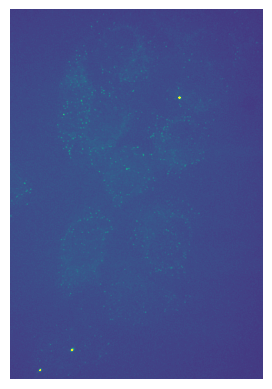

array([[1028., 1003.,  951., ...,  872.,  843., 1009.],
       [ 906.,  911.,  939., ..., 1053., 1326.,  768.],
       [ 961.,  962.,  908., ...,  813.,  849., 1081.],
       ...,
       [1304.,  932.,  996., ...,  973.,  782.,  890.],
       [1042., 1068.,  853., ...,  877.,  914.,  888.],
       [1069.,  981., 1086., ...,  837.,  786.,  879.]], dtype=float32)

In [14]:
Display().displayImage_maxProject(0, 0, 0)

In [15]:
# Display().displayMask(channel=2, position=10)

Let run some Image Processing

INFO:cellpose.models:>> nuclei << model set to be used


++++++++++++++++++++++++++++
Running :  SimpleCellposeSegmentaion
++++++++++++++++++++++++++++

 ###################### 
FOV:0 TIMEPOINT: 0
 ###################### 


INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [0, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.79 sec
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>>>> loading model C:\Users\Jack\.cellpose\models\cyto3
IN

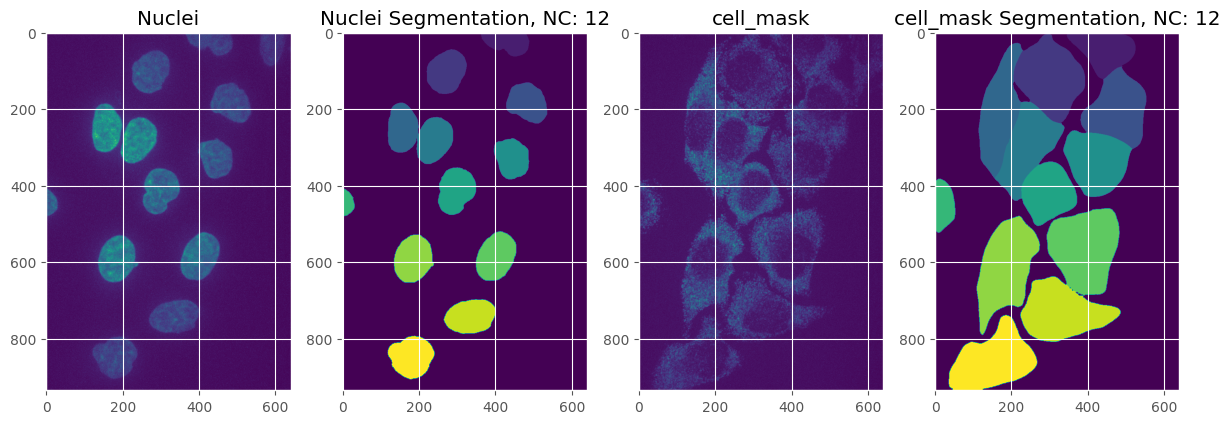

Overwriting masks in DataContainer


OSError: [Errno 22] Invalid argument: 'temp_19969_masks\\8.npy'

In [16]:
# start with segmentation. 
# these steps are built with ther own logic in mind so read the doc string to see all the options
# this class assume that if you are running it you want to overide the previous masks
# there are also several other options that you can set by adding them to the settings object
settings.cellpose_min_size = 500
settings.cellpose_diameter = [180, 90] # most of these options can be done for individually cyto and nuc segmentation, 
                                        # and a list can be or a single float can be passed for both
                                        # always in the order cyto, nuc
settings.cellpose_pretrained_model = ["GAPDH_cyto", 'DAPI_nuclei'] 

SimpleCellposeSegmentaion().run() # this will run the step

# this code will overwrite the previous masks and a warning will be given

In [ ]:
print(data)

In [ ]:
# Lets do spot detection
BIGFISH_SpotDetection().run()

Save the generated results

In [ ]:
print(data)


In [ ]:
# Save Masks
# this has to be a dedicated step because overwriting the masks is a big deal
# this needs to be ran first before h5_file are closed
Save_Masks().run()

# IF YOU EVER GET A ERROR CODE WINERROR 33, YOU PROBABLY HAVE THE H5 FILE OPEN IN ANOTHER PROGRAM.
# I.E., YOU HAVE ANOTHER FILE OPEN

In [ ]:
print(data)


In [ ]:
# This will save the data to the H5 file that is the standard data format
# It will save them to the Analysis group with the name of the analysis and todays data
Save_Outputs().run()

In [ ]:
# Save parameters
Save_Parameters().run()

In [ ]:
# Save images
# this is not recommended to do unless you want to save the images that you have processed
# this will be save to the analysis group in the H5 file and will not overwrite the raw images
# Save_Images().run()

In [ ]:
# send back to NAS
return_to_NAS().run()

In [ ]:
remove_temp().run()

# Summary

In [ ]:
# clear outputs
OutputClass.clear_instances()
Parameters.clear_instances()
print(Parameters.get_parameters())  
print(OutputClass.get_all_instances())

In [ ]:
# first we have to set up our parameters
scope = ScopeClass(spot_yx = 130, 
    spot_z = 360, 
    voxel_size_yx = 100
) 
data = DataContainer()
settings = Settings(
    name='demo',
    num_chunks_to_run = 1
)
experiment = Experiment(
    initial_data_location = r'smFISH_images\Eric_smFISH_images\20230511\DUSP1_DexTimeConcSweep_10nM_75min_041223',
    FISHChannel = 0,
    nucChannel = 2,
    voxel_size_z = 500
)
# we can add additional parameters
settings.cellpose_min_size = 500
settings.cellpose_diameter = [180, 90] # most of these options can be done for individually cyto and nuc segmentation, 
                                        # and a list can be or a single float can be passed for both
                                        # always in the order cyto, nuc
settings.cellpose_pretrained_model = [r"C:\Users\Jack\Documents\GitHub\FISH_Processing\models\GAPDH_cyto", r'C:\Users\Jack\Documents\GitHub\FISH_Processing\models\DAPI_nuclei'] 

# we can also check the parameters and make sure they will work
Parameters.validate()

# these parameter will find there way into the steps we wish to run
FFF2NativeDataType().run()
SimpleCellposeSegmentaion().run()
BIGFISH_SpotDetection().run()

# Save ( you would normally want to run this but it will duplicate data if you do it all at once i.e., hitting run all)
# Save_Masks().run() 
# Save_Outputs().run()
# Save_Parameters().run()

In [ ]:
remove_all_temp().run